## Analise dos Dados da Covid 19 no ano de 2020 no Brasil.
###Dados públicos do BigQuery. ID da tabela: bigquery-public-data.covid19_open_data.covid19_open_data


In [7]:
!pip install pandas-gbq --quiet

import pandas as pd
from pandas_gbq import read_gbq
from google.colab import auth
import numpy as np
import matplotlib.pyplot as plt


auth.authenticate_user()

PROJECT_ID = "prime-pod-472415-d7"
TABLE = "bigquery-public-data.covid19_open_data.covid19_open_data"
START = "2020-01-01"
END   = "2020-12-31"
pd.set_option("display.max_rows", 100)


In [12]:
# Brasil (nível país)
q_br = f"""
SELECT
  date,
  new_confirmed,
  new_deceased,
  cumulative_confirmed,
  cumulative_deceased
FROM `{TABLE}`
WHERE country_name = 'Brazil'
  AND subregion1_name IS NULL
  AND date BETWEEN '{START}' AND '{END}'
ORDER BY date
"""

# UFs (somente BR_XX)
q_uf = f"""
SELECT
  date,
  location_key,
  subregion1_name AS state,
  new_confirmed,
  new_deceased,
  cumulative_confirmed,
  cumulative_deceased
FROM `{TABLE}`
WHERE country_name = 'Brazil'
  AND subregion1_name IS NOT NULL
  AND subregion2_name IS NULL
  AND REGEXP_CONTAINS(location_key, r'^BR_[A-Z]{{2}}$')  -- trava em UF
  AND date BETWEEN '{START}' AND '{END}'
ORDER BY date
"""

br = read_gbq(q_br, project_id=PROJECT_ID, dialect="standard")
uf = read_gbq(q_uf, project_id=PROJECT_ID, dialect="standard")

br["date"] = pd.to_datetime(br["date"])
uf["date"] = pd.to_datetime(uf["date"])

print("Linhas BR 2020:", len(br), "| Datas:", br["date"].min(), "→", br["date"].max())
print("Linhas UF 2020:", len(uf), "| UFs distintas:", uf["location_key"].nunique())


Downloading: 100%|██████████|
Downloading: 100%|██████████|
Linhas BR 2020: 366 | Datas: 2020-01-01 00:00:00 → 2020-12-31 00:00:00
Linhas UF 2020: 9882 | UFs distintas: 27


In [13]:
# Rótulo único por UF (resolve variações tipo "Distrito Federal"/"Federal District")
label_map = (
    uf.dropna(subset=["state"])
      .groupby("location_key")["state"]
      .agg(lambda s: s.value_counts().idxmax())
      .to_dict()
)
uf["state"] = uf["location_key"].map(label_map)

# Ordena para calcular diferenças corretamente
uf = uf.sort_values(["location_key", "date"]).reset_index(drop=True)
br = br.sort_values("date").reset_index(drop=True)

# Converte para numérico (evita erros com None/strings)
for c in ["new_confirmed","new_deceased","cumulative_confirmed","cumulative_deceased"]:
    uf[c] = pd.to_numeric(uf[c], errors="coerce")
    br[c] = pd.to_numeric(br[c], errors="coerce")

# Casos diários UF (fallback a partir do acumulado quando preciso)
uf_cases_calc = (uf.groupby("location_key")["cumulative_confirmed"].diff()).fillna(0).clip(lower=0)
uf["cases_day"] = np.where(uf["new_confirmed"].notna(), uf["new_confirmed"], uf_cases_calc)

# Óbitos diários UF (fallback)
uf_deaths_calc = (uf.groupby("location_key")["cumulative_deceased"].diff()).fillna(0).clip(lower=0)
uf["deaths_day"] = np.where(uf["new_deceased"].notna(), uf["new_deceased"], uf_deaths_calc)

# Nacional (mesma lógica)
br_cases_calc = br["cumulative_confirmed"].diff().fillna(0).clip(lower=0)
br["cases_day"] = np.where(br["new_confirmed"].notna(), br["new_confirmed"], br_cases_calc)

br_deaths_calc = br["cumulative_deceased"].diff().fillna(0).clip(lower=0)
br["deaths_day"] = np.where(br["new_deceased"].notna(), br["new_deceased"], br_deaths_calc)

# Sanidade
print("Duplicatas UF (date+location_key):", uf.duplicated(["date","location_key"]).sum())
print("location_key só UF? ", (~uf["location_key"].str.match(r"^BR_[A-Z]{2}$")).any() == False)


Duplicatas UF (date+location_key): 0
location_key só UF?  True


In [14]:
rank_cases = (
    uf.groupby(["location_key","state"], as_index=False)["cases_day"]
      .sum()
      .rename(columns={"cases_day":"cases_2020"})
      .sort_values("cases_2020", ascending=False)
)
rank_cases.head(10)


,location_key,state,cases_2020
25,BR_SP,São Paulo,1465311.0
10,BR_MG,Minas Gerais,544629.0
4,BR_BA,Bahia,494223.0
23,BR_SC,Santa Catarina,493849.0
22,BR_RS,Rio Grande do Sul,450081.0
18,BR_RJ,Rio de Janeiro,435508.0
17,BR_PR,Paraná,416624.0
5,BR_CE,Ceará,335342.0
8,BR_GO,Goiás,309363.0
13,BR_PA,Pará,293881.0


Ranking por estado (2020)
Métrica: soma de cases_day por UF no ano.
Visual: barras (Top 10).
Insight esperado: concentração de casos em poucos estados.

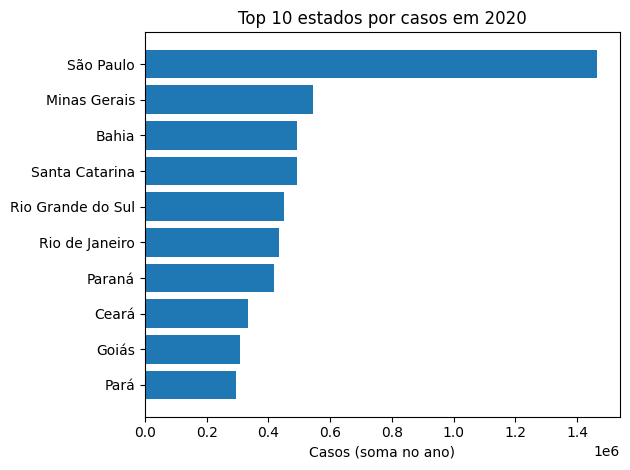

In [15]:
top10 = rank_cases.head(10)
plt.figure()
plt.barh(top10["state"][::-1], top10["cases_2020"][::-1])
plt.title("Top 10 estados por casos em 2020")
plt.xlabel("Casos (soma no ano)")
plt.tight_layout(); plt.show()


Evolução mensal nacional
Métrica: soma de cases_day por mês (Brasil).
Visual: linha mensal.
Insight esperado: identificação do(s) pico(s).

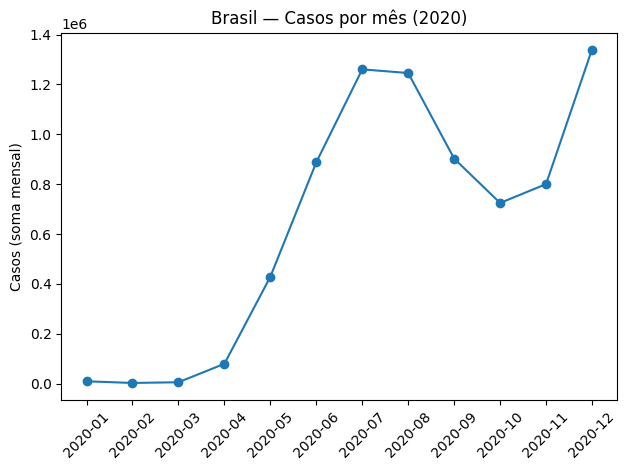

In [17]:
br_m = (
    br.assign(month = br["date"].dt.to_period("M").astype(str))
      .groupby("month", as_index=False)["cases_day"].sum()
      .rename(columns={"cases_day":"cases_month"})
)
br_m

plt.figure()
plt.plot(br_m["month"], br_m["cases_month"], marker="o")
plt.title("Brasil — Casos por mês (2020)")
plt.ylabel("Casos (soma mensal)")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


CFR por estado (2020)
Métrica: óbitos_2020 / casos_2020 (%).
Nota: sensível a testagem/subnotificação; comparar apenas entre UFs.

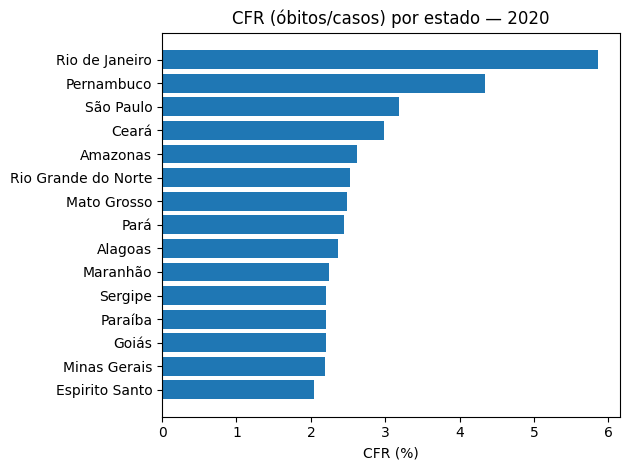

In [18]:
agg = (
    uf.groupby(["location_key","state"], as_index=False)[["cases_day","deaths_day"]]
      .sum()
      .rename(columns={"cases_day":"cases_2020", "deaths_day":"deaths_2020"})
)
agg["CFR_%"] = (agg["deaths_2020"] / agg["cases_2020"].replace(0, np.nan)) * 100
cfr_rank = agg.sort_values("CFR_%", ascending=False)
cfr_rank.head(15)
top15_cfr = cfr_rank.dropna(subset=["CFR_%"]).head(15)
plt.figure()
plt.barh(top15_cfr["state"][::-1], top15_cfr["CFR_%"][::-1])
plt.title("CFR (óbitos/casos) por estado — 2020")
plt.xlabel("CFR (%)")
plt.tight_layout(); plt.show()


Mês de pico: composição por estado
Passos: achar mês de pico (nacional) → distribuição por UF.
Visual: barras (Top 10).
Insight: concentração vs. dispersão no pico.

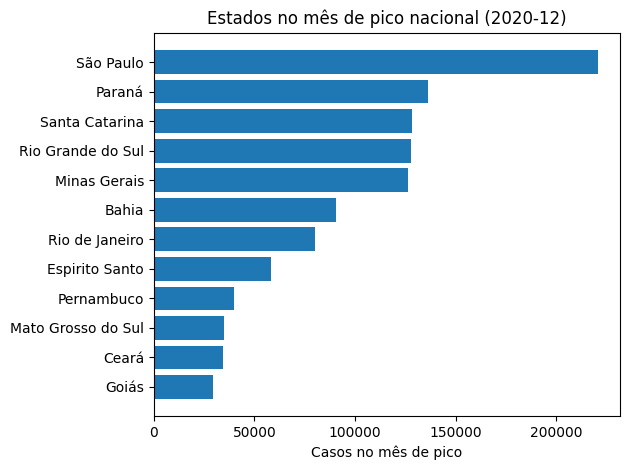

In [19]:
peak_month = br_m.loc[br_m["cases_month"].idxmax(), "month"]
peak_month

uf_m = (
    uf.assign(month = uf["date"].dt.to_period("M").astype(str))
      .groupby(["month","location_key","state"], as_index=False)["cases_day"]
      .sum()
)

comp_peak = (
    uf_m.query("month == @peak_month")
        .sort_values("cases_day", ascending=False)
        .rename(columns={"cases_day":"cases_in_peak_month"})
)
comp_peak.head(12)
top12 = comp_peak.head(12)
plt.figure()
plt.barh(top12["state"][::-1], top12["cases_in_peak_month"][::-1])
plt.title(f"Estados no mês de pico nacional ({peak_month})")
plt.xlabel("Casos no mês de pico")
plt.tight_layout(); plt.show()


In [22]:
peak_month = br_m.loc[br_m["cases_month"].idxmax(), "month"]
peak_total = int(br_m["cases_month"].max())
print(f"Pico nacional (2020): mês {peak_month}, com {peak_total:,} casos.".replace(",", "."))

top3 = rank_cases.head(3).copy()
total_year = rank_cases["cases_2020"].sum()
z_pct = float(top3["cases_2020"].sum() / total_year * 100)
print("Top estados do ano:")
for i, r in top3.iterrows():
    print(f"- {r['state']}: {int(r['cases_2020']):,} casos".replace(",", "."))
print(f"Esses 3 estados concentraram {z_pct:.1f}% dos casos de 2020.")

cfr_rank_clean = cfr_rank.query("cases_2020 >= 1000")
top_cfr = cfr_rank_clean.head(2) if len(cfr_rank_clean)>=2 else cfr_rank.head(2)
print("Maiores CFR (óbitos/casos) em 2020:")
for i, r in top_cfr.iterrows():
    print(f"- {r['state']}: {r['CFR_%']:.2f}%")
peak_month = br_m.loc[br_m["cases_month"].idxmax(), "month"]
peak_table = comp_peak.sort_values("cases_in_peak_month", ascending=False)
tot_peak = peak_table["cases_in_peak_month"].sum()
p_pct = float(peak_table.head(2)["cases_in_peak_month"].sum() / tot_peak * 100)
print(f"No mês de pico ({peak_month}), os dois estados com mais casos somaram {p_pct:.1f}% do total.")
print("Top 5 do mês de pico:")
for i, r in peak_table.head(5).iterrows():
    print(f"- {r['state']}: {int(r['cases_in_peak_month']):,} casos".replace(",", "."))



Pico nacional (2020): mês 2020-12. com 1.340.095 casos.
Top estados do ano:
- São Paulo: 1.465.311 casos
- Minas Gerais: 544.629 casos
- Bahia: 494.223 casos
Esses 3 estados concentraram 32.6% dos casos de 2020.
Maiores CFR (óbitos/casos) em 2020:
- Rio de Janeiro: 5.86%
- Pernambuco: 4.34%
No mês de pico (2020-12), os dois estados com mais casos somaram 26.6% do total.
Top 5 do mês de pico:
- São Paulo: 220.644 casos
- Paraná: 136.482 casos
- Santa Catarina: 128.239 casos
- Rio Grande do Sul: 127.616 casos
- Minas Gerais: 126.574 casos


Conclusões
Resumo dos achados (pico, top estados, CFR, composição) + limitações e próximos passos.

Conclusões — COVID-19 no Brasil (2020)

Pico nacional (2020): mês 2020-12, com 1.340.095 casos.

Top estados do ano: São Paulo (1.465.311), Minas Gerais (544.629) e Bahia (494.223) concentraram 32,6% dos casos de 2020.

CFR (óbitos/casos): maiores em Rio de Janeiro (5,86%) e Pernambuco (4,34%).
Observação: a CFR é influenciada por testagem e subnotificação — compare de forma relativa entre UFs.

Mês de pico (2020-12): os dois estados com mais casos somaram 26,6% do total.
Top 5 no pico: São Paulo (220.644), Paraná (136.482), Santa Catarina (128.239), Rio Grande do Sul (127.616), Minas Gerais (126.574).
